In [24]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import norm  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap
from collections import deque

In [25]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [26]:
train_dataset = u5_train_equil_pump
test_dataset = u5_s02_equil_pump
real_dataset = u5_test_equil_pump

In [27]:
features = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position', 'pump_calculated_flow', 
            'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed', 
            'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'turbine_cycle_id', 
            'pump_cycle_id', 'scaled_injector_sum',
            'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos',
            # 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear',
            'tot_activepower_lag_1', 'tot_activepower_lag_3', 
            'tot_activepower_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 
            'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'coupler_position_lag_1', 
            'coupler_position_lag_3', 'coupler_position_lag_10', 'pump_calculated_flow_lag_1', 
            'pump_calculated_flow_lag_3', 'pump_calculated_flow_lag_10', 'pump_pressure_diff_lag_1', 
            'pump_rotspeed_lag_1', 'pump_rotspeed_lag_3', 'pump_rotspeed_lag_10', 'turbine_pressure_lag_1', 
            'turbine_pressure_lag_3', 'turbine_pressure_lag_10', 'turbine_rotspeed_lag_1', 
            'turbine_rotspeed_lag_3', 'turbine_rotspeed_lag_10', 'water_primary_pump_01_opening_lag_1', 
            'water_primary_pump_01_opening_lag_3', 'water_primary_pump_01_opening_lag_10', 
            'water_primary_pump_02_opening_lag_1', 'water_primary_pump_02_opening_lag_3', 
            'water_primary_pump_02_opening_lag_10', 'turbine_cycle_id_lag_1', 'turbine_cycle_id_lag_3', 
            'turbine_cycle_id_lag_10', 'pump_cycle_id_lag_1', 'pump_cycle_id_lag_3', 'pump_cycle_id_lag_10'
        ]


In [28]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in train_dataset.columns]

target_features = ['charge', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'air_circ_cold_01_tmp', 
    'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 
    'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 
    'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 
    'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 
    'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 
    'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 
    'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_tmp', 'stat_coil_ph02_02_tmp', 
    'stat_coil_ph02_03_tmp', 'stat_coil_ph02_04_tmp', 'stat_coil_ph02_05_tmp', 'stat_coil_ph02_06_tmp', 
    'stat_coil_ph03_01_tmp', 'stat_coil_ph03_02_tmp', 'stat_coil_ph03_03_tmp', 'stat_coil_ph03_04_tmp', 
    'stat_coil_ph03_05_tmp', 'stat_coil_ph03_06_tmp', 'stat_magn_01_tmp', 'stat_magn_02_tmp', 
    'stat_magn_03_tmp', 'stat_magn_04_tmp', 'stat_magn_05_tmp', 'stat_magn_06_tmp', 'stat_magn_07_tmp', 
    'stat_magn_08_tmp', 'stat_magn_09_tmp', 'stat_magn_10_tmp', 'stat_magn_11_tmp', 'stat_magn_12_tmp', 
    'water_circ_cold_tmp', 'water_circ_flow', 'water_circ_hot_01_tmp', 'water_circ_hot_02_tmp', 
    'water_circ_hot_03_tmp', 'water_circ_hot_04_tmp', 'water_circ_hot_05_tmp', 'water_circ_hot_06_tmp', 
    'water_circ_hot_tmp', 'air_gap_negative_x_position', 'air_gap_positive_x_position', 
    'air_gap_negative_y_position', 'air_gap_positive_y_position'
    ]

# Split the data into source and target sets (we will regress the source variables onto the target variables)
train = train_dataset[features]
y = train_dataset[target_features]

In [29]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error
# from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to tune
#     # n_estimators = trial.suggest_int('n_estimators', 10, 100)
#     n_estimators = trial.suggest_int('n_estimators', 3, 20)
#     max_depth = trial.suggest_int('max_depth', 3, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # 'auto' removed

#     # Create the RandomForestRegressor with the suggested hyperparameters
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Train the model
#     model.fit(X_train, y_train)

#     # Predict on the validation set
#     y_val_pred = model.predict(X_val)

#     # Calculate RMSE as the evaluation metric
#     rmse = root_mean_squared_error(y_val, y_val_pred)
#     return rmse


# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Number of trials

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params

Best hyperparameters: {'n_estimators': 20, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [30]:
# # If ran the optuna study before
# best_params = study.best_params 

# Otherwise
best_params = {'n_estimators': 20, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}

In [31]:
final_model = RandomForestRegressor(
    n_estimators=3, # for faster computation
    # n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

final_model.fit(train, y)

RandomForestRegressor(max_depth=25, max_features=None, n_estimators=3,
                      random_state=42)

## K-fold Cross Validation

In [32]:
def temporal_kfold_threshold_selection(dataset, features, target_features, n_splits=5):
    # Create Time Series Cross-Validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store residuals for each fold
    all_residuals = []
    
    # Perform temporal cross-validation
    for train_index, val_index in tscv.split(dataset[features]):
        # Split data temporally
        X_train, X_val = dataset[features].iloc[train_index], dataset[features].iloc[val_index]
        y_train, y_val = dataset[target_features].iloc[train_index], dataset[target_features].iloc[val_index]
        
        # Train model
        model = RandomForestRegressor(
            n_estimators=3, # for faster computation
            # n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Predict and compute residuals
        y_pred = model.predict(X_val)
        residuals = y_val.values - y_pred
        all_residuals.append(residuals)
    
    # Combine residuals across folds
    combined_residuals = np.concatenate(all_residuals)

    return combined_residuals

In [33]:
combined_residuals = temporal_kfold_threshold_selection(train_dataset, features, target_features)

## Finding optimal thresholds

### Method 1: Global threshold based on residual norms

In [ ]:
residuals_norm = np.linalg.norm(combined_residuals, axis=1)

mean_norm = np.mean(residuals_norm)
std_norm = np.std(residuals_norm)
glob_threshold = mean_norm + 1 * std_norm

In [69]:
print(glob_threshold)

1.754272633376361


### Method 2: Individual statistical feature thresholds

In [ ]:
def individual_thresholds(combined_residuals):
    # Compute thresholds (1-sigma method)
    feature_thresholds = {}
    for i, feature in enumerate(target_features):
        feature_residuals = combined_residuals[:, i]
        mean = np.mean(feature_residuals)
        std = np.std(feature_residuals)
        feature_thresholds[feature] = {
            'mean': mean,
            'std': std,
            'threshold': mean + 1 * std
        }
    return feature_thresholds

In [54]:
feature_thresholds = individual_thresholds(combined_residuals)

In [55]:
# Print thresholds
for feature, stats in feature_thresholds.items():
    print(f"{feature}: Mean={stats['mean']:.4f}, Std={stats['std']:.4f}, 3-Sigma Threshold={stats['threshold']:.4f}")

charge: Mean=0.0000, Std=0.0133, 3-Sigma Threshold=0.0067
tot_current: Mean=0.0292, Std=0.1661, 3-Sigma Threshold=0.1122
tot_effectivepower: Mean=-0.0139, Std=0.1411, 3-Sigma Threshold=0.0566
tot_reactivepower: Mean=-0.1051, Std=0.2761, 3-Sigma Threshold=0.0329
air_circ_cold_01_tmp: Mean=0.0900, Std=0.1995, 3-Sigma Threshold=0.1898
air_circ_cold_02_tmp: Mean=0.0904, Std=0.2015, 3-Sigma Threshold=0.1912
air_circ_cold_03_tmp: Mean=0.0901, Std=0.1997, 3-Sigma Threshold=0.1900
air_circ_cold_04_tmp: Mean=0.0902, Std=0.1998, 3-Sigma Threshold=0.1900
air_circ_cold_05_tmp: Mean=0.0903, Std=0.1998, 3-Sigma Threshold=0.1902
air_circ_cold_06_tmp: Mean=0.0893, Std=0.1993, 3-Sigma Threshold=0.1889
air_circ_hot_01_tmp: Mean=0.0572, Std=0.1340, 3-Sigma Threshold=0.1242
air_circ_hot_02_tmp: Mean=0.0572, Std=0.1334, 3-Sigma Threshold=0.1239
air_circ_hot_03_tmp: Mean=0.0589, Std=0.1363, 3-Sigma Threshold=0.1270
air_circ_hot_04_tmp: Mean=0.0585, Std=0.1357, 3-Sigma Threshold=0.1264
air_circ_hot_05_tmp: M

# Test

## Getting predictions

In [56]:
# For the synthetic test set
X_synthetic = test_dataset[features]
y_synthetic = test_dataset[target_features]

In [57]:
# Predict on synthetic dataset
y_pred_synthetic = final_model.predict(X_synthetic)
residuals_synthetic = y_pred_synthetic - y_synthetic

# Compute the norm of the synthetic test residuals
residuals_synthetic_norm = np.linalg.norm(residuals_synthetic, axis=1)

# Get true anomalies
true_anomalies = test_dataset['anomaly']

## Overall Model Evalutations

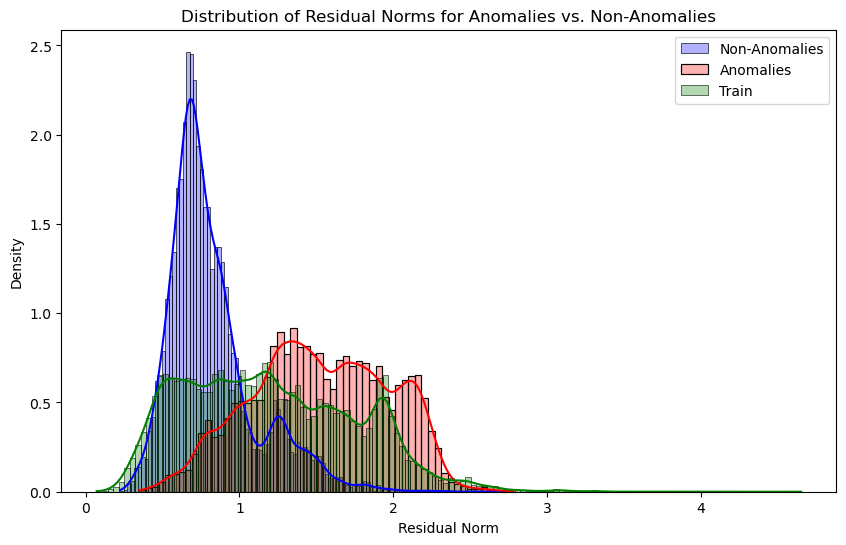

In [58]:
true_anomalies = test_dataset['anomaly']
norm_anomalies = residuals_synthetic_norm[true_anomalies == 1]
norm_non_anomalies = residuals_synthetic_norm[true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(norm_non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.3)
sns.histplot(norm_anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.3)
sns.histplot(residuals_norm, kde=True, color="green", label="Train", stat='density', alpha=0.3)

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
# plt.yscale('log')
# plt.xscale('log')
# plt.xticks([])
plt.legend()
plt.show()

AUC: 0.9052249943397391


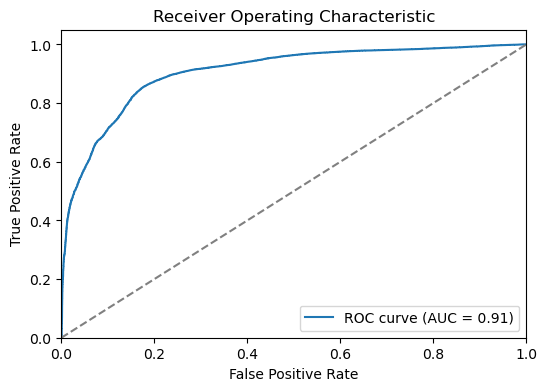

In [59]:
# ROC Curve and AUC
# Use the continuous residual norm as the "score" for ROC
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_synthetic_norm)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Plot the ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

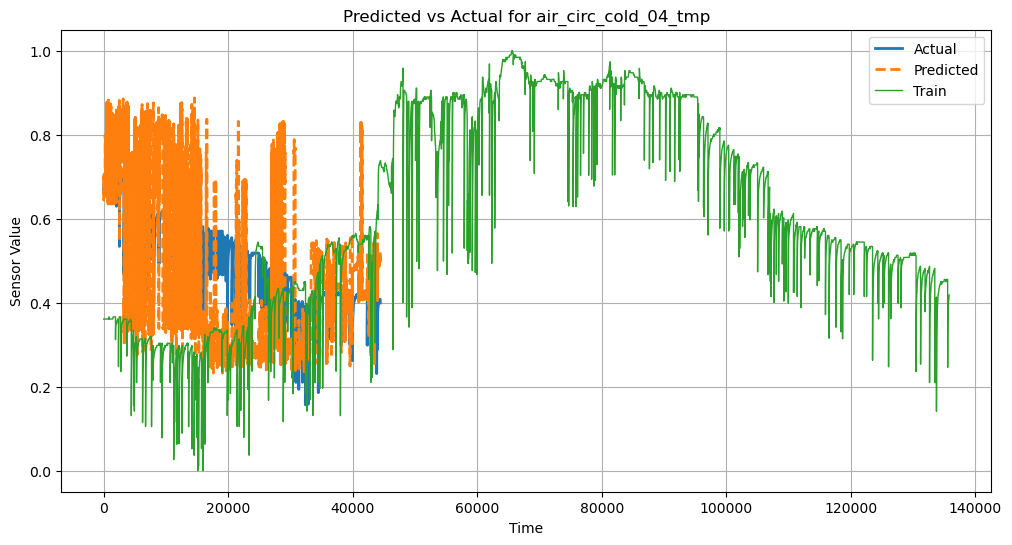

In [70]:
# Specify the sensor (output dimension) you want to visualize
sensor_name = 'air_circ_cold_04_tmp'  # Replace with the name of the sensor

# Extract the actual and predicted values for the chosen sensor
actual_values = y_synthetic[sensor_name].values  # True values for the sensor
train_values = y[sensor_name].values # Training values
predicted_values = y_pred_synthetic[:, y_synthetic.columns.get_loc(sensor_name)]  # Predicted values

# Plot the actual and predicted time series
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', linewidth=2)
plt.plot(predicted_values, label='Predicted', linewidth=2, linestyle='--')
plt.plot(train_values, label='Train', linewidth=1, linestyle='-')
plt.title(f'Predicted vs Actual for {sensor_name}')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.show()

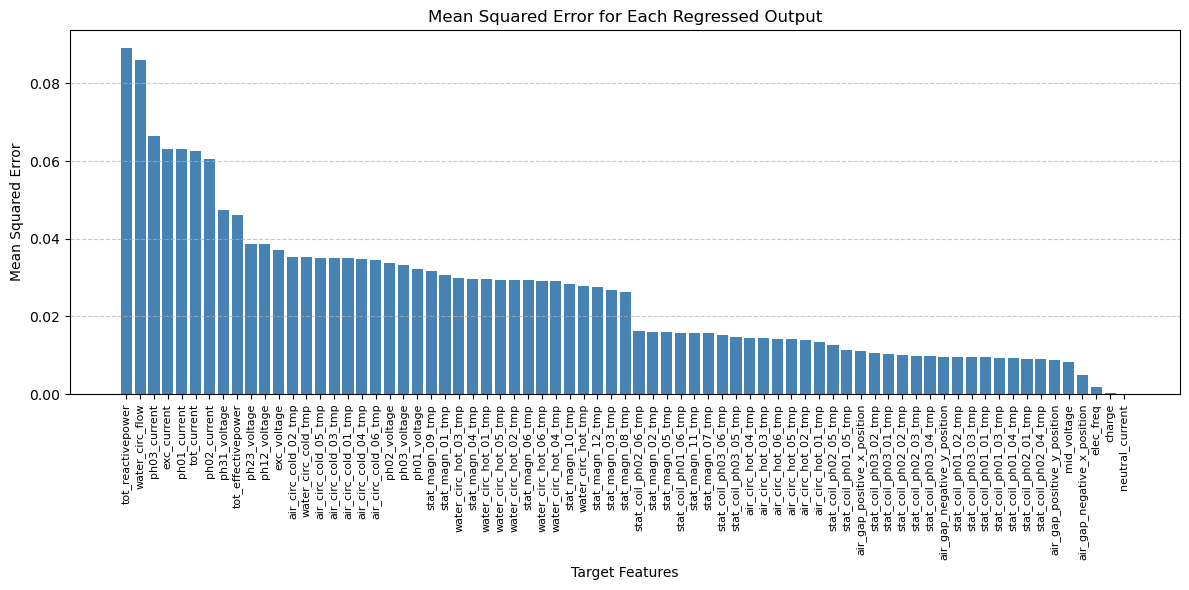

In [71]:
mse_per_feature = {}
for feature in target_features:
    true_values = y_synthetic[feature].values
    predicted_values = y_pred_synthetic[:, y_synthetic.columns.get_loc(feature)]
    mse = np.mean((true_values - predicted_values) ** 2)
    mse_per_feature[feature] = mse

# Sort MSE values in descending order for better visualization
sorted_mse = dict(sorted(mse_per_feature.items(), key=lambda item: item[1], reverse=True))

# Plot MSE for each target feature
plt.figure(figsize=(12, 6))
plt.bar(sorted_mse.keys(), sorted_mse.values(), color='steelblue')
plt.xticks(rotation=90, fontsize=8)  # Rotate feature names for better readability
plt.xlabel('Target Features')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error for Each Regressed Output')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Using method 1 (global threshold)

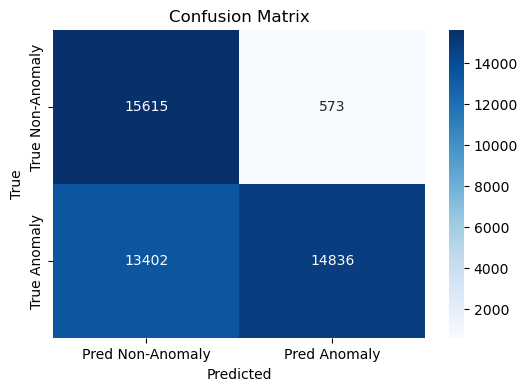

Accuracy: 0.6854319542610183
F1-score: 0.6798176277865604
 R squared: -0.3581942865781349


In [ ]:
predicted_anomalies = (residuals_synthetic_norm >= glob_threshold).astype(int)

acc = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
r2 = r2_score(true_anomalies, predicted_anomalies)
cm = confusion_matrix(true_anomalies, predicted_anomalies)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Non-Anomaly', 'Pred Anomaly'], 
            yticklabels=['True Non-Anomaly', 'True Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", acc)
print("F1-score:", f1)
print(" R squared:", r2)

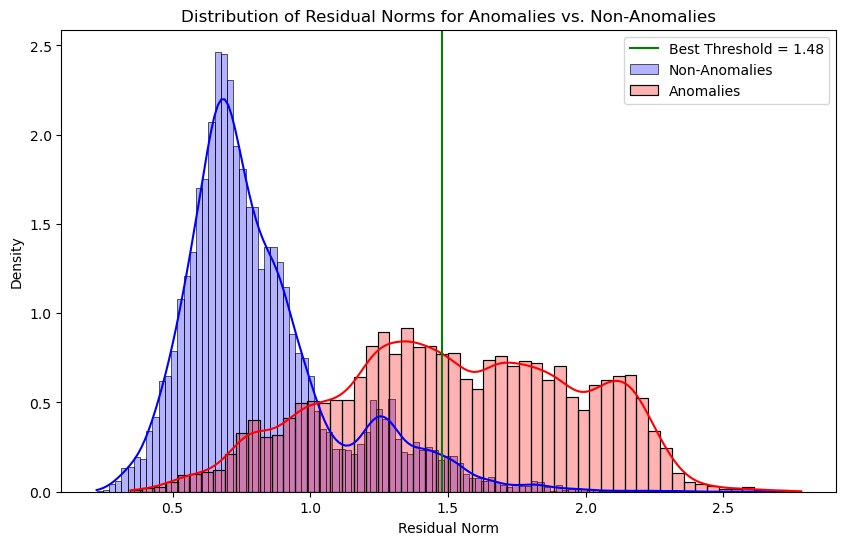

In [66]:
anomalies = residuals_synthetic_norm[true_anomalies == 1]
non_anomalies = residuals_synthetic_norm[true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.3)
sns.histplot(anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.3)
plt.axvline(x=glob_threshold, color='green', linestyle='-', label=f'Best Threshold = {glob_threshold:.2f}')

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
plt.legend()
plt.show()

## Using Threshold method 2 (individual thresholds)

In [ ]:
# Compute feature-wise threshold exceedance
feature_anomaly_counts = (np.abs(residuals_synthetic) > 
    np.array([feature_thresholds[feature]['threshold'] for feature in target_features])).sum(axis=1)

# Predict anomalies based on feature-wise threshold exceedance
predicted_anomalies = (feature_anomaly_counts > len(target_features) * 0.3).astype(int) # if 30% of values signal an anomaly, flag

# Performance metrics
acc = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
r2 = r2_score(true_anomalies, predicted_anomalies)
cm = confusion_matrix(true_anomalies, predicted_anomalies)

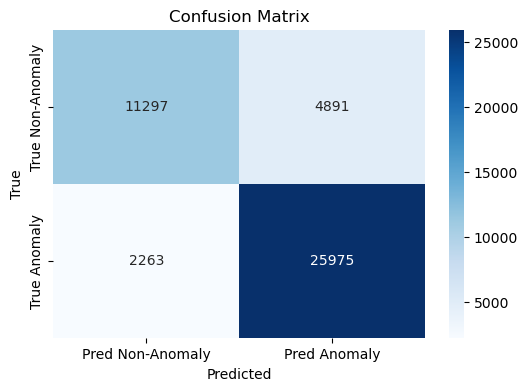

Accuracy: 0.8389681717912933
F1-score: 0.8789591229020033
R squared: 0.30472115018390145


In [93]:
# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Non-Anomaly', 'Pred Anomaly'], 
            yticklabels=['True Non-Anomaly', 'True Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", acc)
print("F1-score:", f1)
print("R squared:", r2)

# Test on real data

## Evaluate

In [74]:
# Prepare input features
X_real = real_dataset[features]
y_real = real_dataset[target_features]

# Predict on real dataset
y_pred_real = final_model.predict(X_real)

# Compute residuals
residuals_real = y_pred_real - y_real

# Compute norm of residuals
residuals_real_norm = np.linalg.norm(residuals_real, axis=1)

## Thresholding, method 1:

In [75]:
# Method 1: Global Threshold Anomaly Detection
global_predicted_anomalies = (residuals_real_norm >= glob_threshold).astype(int)

## Thresholding, Method 2:

In [94]:
# Method 2: Feature-wise Threshold Anomaly Detection
feature_anomaly_counts = (np.abs(residuals_real) > 
    np.array([feature_thresholds[feature]['threshold'] for feature in target_features])).sum(axis=1)
feature_predicted_anomalies = (feature_anomaly_counts > len(target_features) * 0.3).astype(int)

In [96]:
# Summary of Anomalies
print("\nAnomaly Detection Summary:")
print(f"Global Threshold Method - Total Anomalies: {global_predicted_anomalies.sum()}")
print(f"Feature-wise Method - Total Anomalies: {feature_predicted_anomalies.sum()}")

# Intersection of Anomalies
intersection_anomalies = (global_predicted_anomalies & feature_predicted_anomalies).sum()
print(f"Anomalies Detected by Both Methods: {intersection_anomalies}")


Anomaly Detection Summary:
Global Threshold Method - Total Anomalies: 10302
Feature-wise Method - Total Anomalies: 21668
Anomalies Detected by Both Methods: 9624


## Visualizations

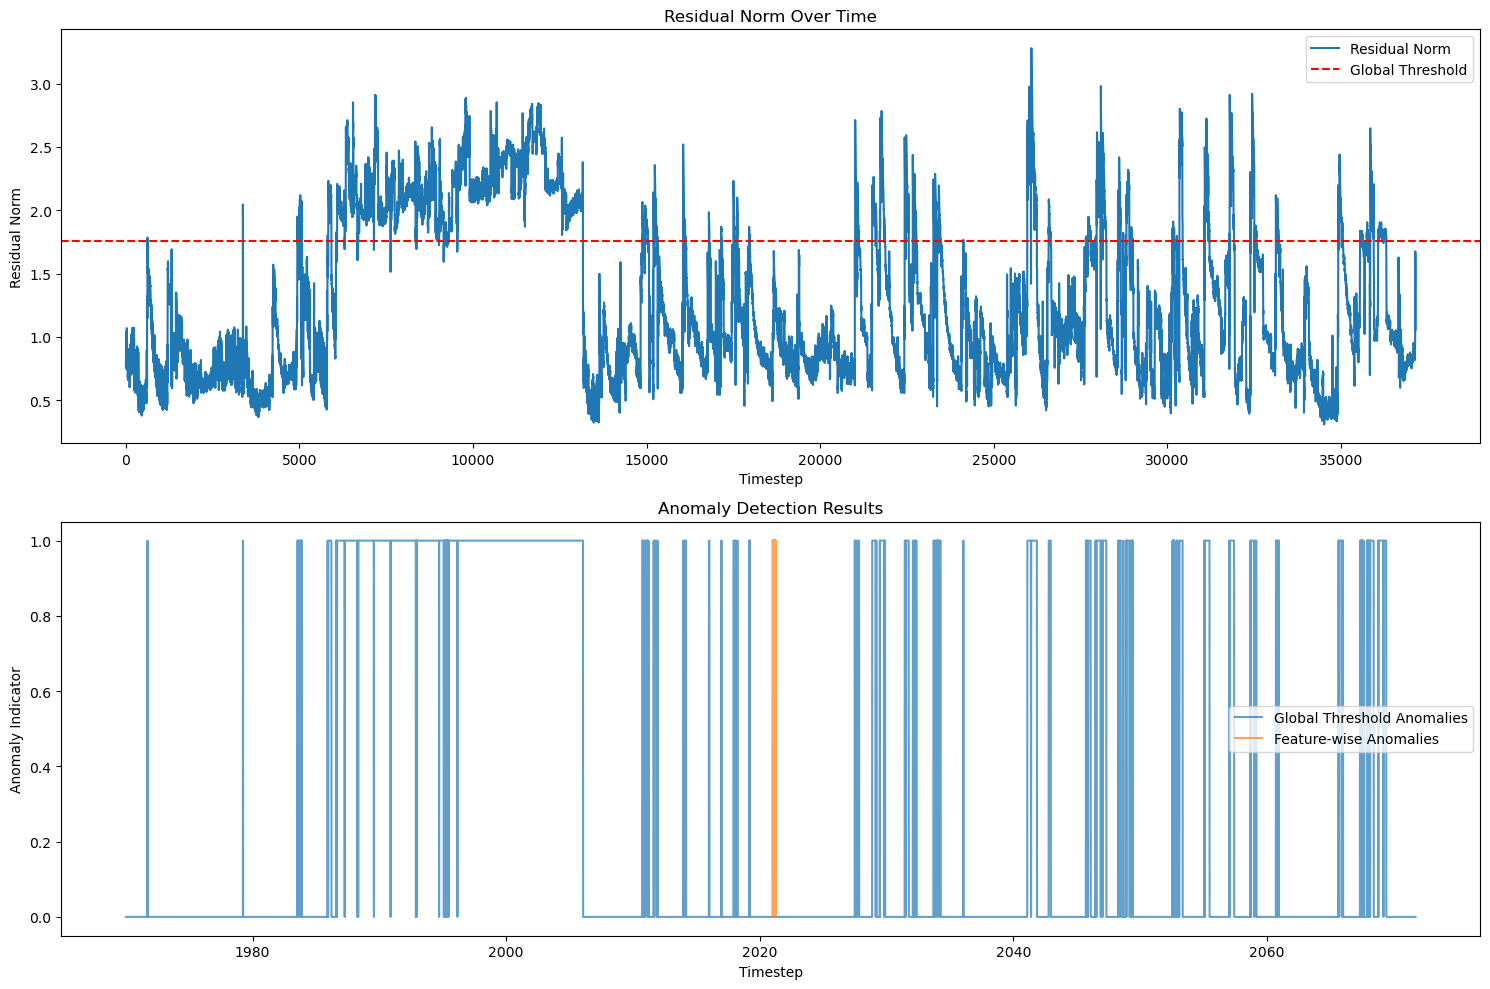

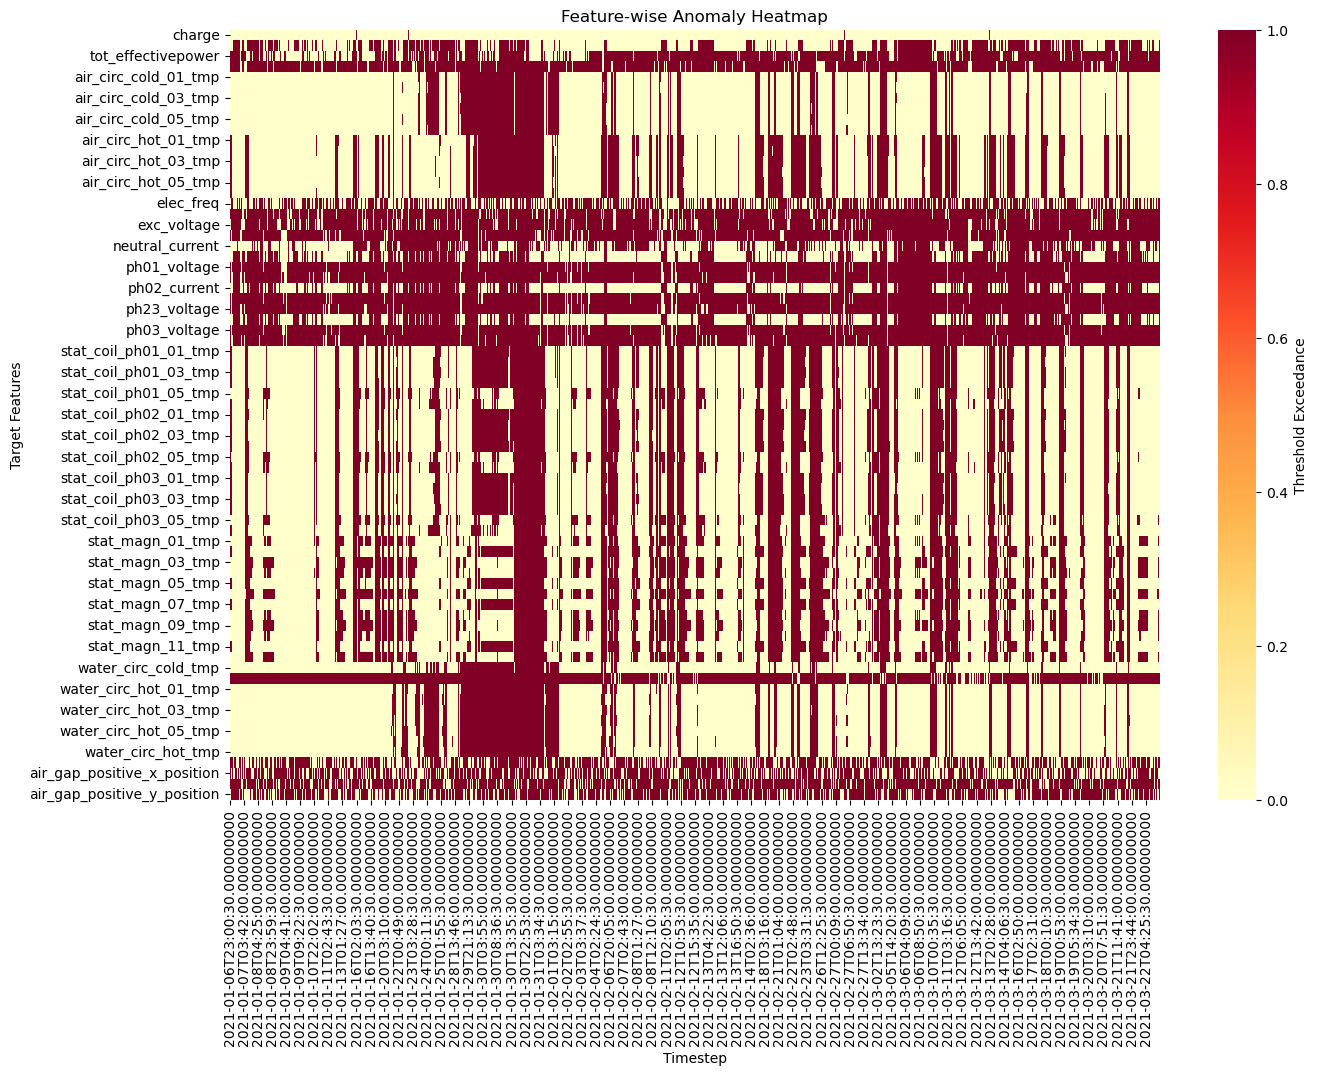


Anomaly Detection Summary:
Global Threshold Method - Total Anomalies: 10302
Feature-wise Method - Total Anomalies: 21668
Anomalies Detected by Both Methods: 9624


array([0.79703504, 0.78029879, 0.75929448, ..., 1.61652078, 1.57272621,
       1.05862353])

In [ ]:
plt.figure(figsize=(15, 10))

# Plot 1: Residual Norm Over Time
plt.subplot(2, 1, 1)
plt.plot(residuals_real_norm, label='Residual Norm')
plt.axhline(y=glob_threshold, color='r', linestyle='--', label='Global Threshold')
plt.title('Residual Norm Over Time')
plt.xlabel('Timestep')
plt.ylabel('Residual Norm')
plt.legend()

# Plot 2: Anomaly Indicators
plt.subplot(2, 1, 2)
plt.plot(global_predicted_anomalies, label='Global Threshold Anomalies', alpha=0.7)
plt.plot(feature_predicted_anomalies, label='Feature-wise Anomalies', alpha=0.7)
plt.title('Anomaly Detection Results')
plt.xlabel('Timestep')
plt.ylabel('Anomaly Indicator')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed Feature Analysis
plt.figure(figsize=(15, 10))
anomaly_heatmap = np.abs(residuals_real) > np.array([feature_thresholds[feature]['threshold'] for feature in target_features])
sns.heatmap(anomaly_heatmap.T, cmap='YlOrRd', cbar_kws={'label': 'Threshold Exceedance'})
plt.title('Feature-wise Anomaly Heatmap')
plt.xlabel('Timestep')
plt.ylabel('Target Features')
plt.show()
